# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [115]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [116]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(file = path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [117]:
def parse_data_line(data_line):
    '''Takes a list corresponding to a data line as input and returns a tuple (label,statement)'''
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)
    label = data_line[1]
    statement = data_line[2]
    return ((label,statement))

In [118]:
# Input: a string of one statement
def pre_process(text):
    '''Returns a list of tokens'''
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    import re
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) 
    tokens = re.split(r"\s+",text)
    return [t.lower() for t in tokens]

### Method 

We import the regular expression library **'re'**. The **re.sub()** method is used to separate words from punctuations occuring at the end and beginning respectively. The **re.split()** method is used to split the text into a list of tokens. We finally convert all tokens to lowercase and return the list of tokens.

# Question 2: Basic Feature Extraction (20 marks)

In [119]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    '''Returns a dictionary of features as keys and their weights as values'''
    feature_vector={}
    for word in set(tokens):
        if word not in global_feature_dict:
            global_feature_dict[word] = tokens.count(word)
        else:
            global_feature_dict[word]+=tokens.count(word)
        feature_vector[word] = 1

    return feature_vector

### Method


We create a dictionary **feature_vector** and use a for loop to parse through every unique word in the tokens list. The dictionary then maps each word to a weight value of '1'. We also update the global_feature_dict everytime the function is called. We finally return the feature_vector dictionary.

In [120]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [121]:
#solution
from sklearn.metrics import classification_report

def cross_validate(dataset, folds):  #dataset is a list of tuples; each tuple containing a feature vector dictionary and a label
    cv_results = {}
    accuracy_scores = []
    positive_precision_scores = []
    positive_recall_scores = []
    positive_f1_scores = []
    negative_precision_scores = []
    negative_recall_scores = []
    negative_f1_scores = []
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        train_data_cv = dataset[:i] + dataset[i+fold_size:]
        classifier = train_classifier(train_data_cv)
        test_data = [k[0] for k in dataset[i:i+fold_size]]
        labels_pred = predict_labels(test_data, classifier)
        labels_true = [k[1] for k in dataset[i:i+fold_size]]
        print("Fold start on items %d - %d" % (i, i+fold_size))
        report = classification_report(labels_true, labels_pred, output_dict=True)
        accuracy_scores.append(report['accuracy'])
        positive_precision_scores.append(report['positive']['precision'])
        positive_recall_scores.append(report['positive']['recall'])
        positive_f1_scores.append(report['positive']['f1-score'])
        negative_precision_scores.append(report['negative']['precision'])
        negative_recall_scores.append(report['negative']['recall'])
        negative_f1_scores.append(report['negative']['f1-score'])
        # FILL IN THE METHOD HERE
    
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_positive_precision = sum(positive_precision_scores) / len(positive_precision_scores)
    avg_positive_recall = sum(positive_recall_scores) / len(positive_recall_scores)
    avg_positive_f1 = sum(positive_f1_scores) / len(positive_f1_scores)
    avg_negative_precision = sum(negative_precision_scores) / len(negative_precision_scores)
    avg_negative_recall = sum(negative_recall_scores) / len(negative_recall_scores)
    avg_negative_f1 = sum(negative_f1_scores) / len(negative_f1_scores)
    
    positive_results = {'precision':avg_positive_precision, 'recall':avg_positive_recall, 'f1-score':avg_positive_f1}
    negative_results = {'precision':avg_negative_precision, 'recall':avg_negative_recall, 'f1-score':avg_negative_f1}
    
    cv_results = {'positive':positive_results, 'negative':negative_results, 'accuracy':avg_accuracy}
        
    return cv_results

In [122]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [123]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
64640


In [124]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...
Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840


{'positive': {'precision': 0.8718679755782487,
  'recall': 0.8963804946206588,
  'f1-score': 0.8839177384295743},
 'negative': {'precision': 0.790582458533277,
  'recall': 0.7477204960373139,
  'f1-score': 0.7684237486410749},
 'accuracy': 0.848318441342039}

### Method

The **cross_validate()** function returns a dictionary containing the average metric scores (precision, recall, f1) of all 10 folds for each class and the average accuracy score.

# Question 4: Error Analysis (20 marks)

In [125]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [126]:
def cv_fold1_data(dataset):
    foldsize=int(len(dataset)/10)
    train_data_cv_fold1 = dataset[foldsize:]
    classifier_fold1 = train_classifier(train_data_cv_fold1)
    test_data_fold1 = [k[0] for k in dataset[:foldsize]]
    labels_pred_fold1 = predict_labels(test_data_fold1, classifier_fold1)
    labels_true_fold1 = [k[1] for k in dataset[:foldsize]]
    cv_fold1_results = classification_report(labels_true_fold1, labels_pred_fold1, output_dict=True)
    _ = cv_fold1_results['positive'].pop('support')
    _ = cv_fold1_results['negative'].pop('support')
    _ = cv_fold1_results.pop('weighted avg')
    _ = cv_fold1_results.pop('macro avg')
    cv_fold1_results['y_true'] = labels_true_fold1
    cv_fold1_results['y_pred'] = labels_pred_fold1
    return cv_fold1_results

Training Classifier...


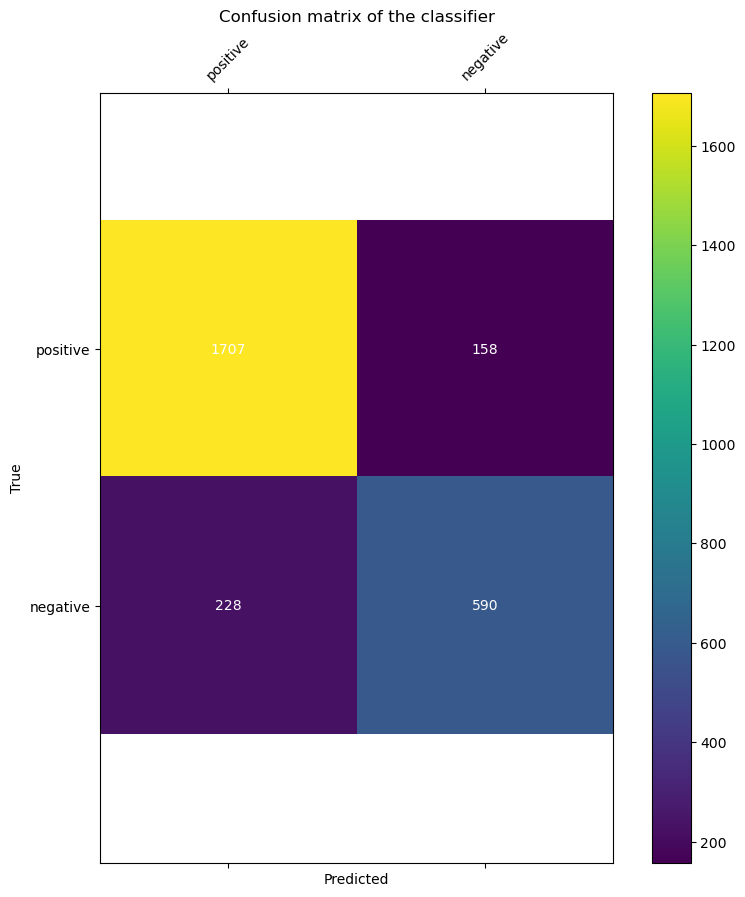

In [127]:
fold1_results = cv_fold1_data(train_data)
confusion_matrix_heatmap(fold1_results['y_true'], fold1_results['y_pred'], ['positive','negative'])

## Error Analysis of False Positives 

In [128]:
foldsize = int(len(train_data) / 10)
output_file_path = 'False_Positives.txt'

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for c, (text, label) in enumerate(raw_data[:foldsize]):
        prediction = fold1_results['y_pred'][c]
        if prediction == label:
            continue
        if not label == 'negative':
            continue
        output_file.write('**** FALSE POSITIVE (ground truth = {1}):****\n\n {0}\n'.format(text, label))
        output_file.write('*' * 50 + '\n\n')

## Error Analysis of False Negatives 

In [129]:
foldsize = int(len(train_data) / 10)
output_file_path = 'False_Negatives.txt'

with open(output_file_path, 'w', encoding='utf-8') as output_file:
    for c, (text, label) in enumerate(raw_data[:foldsize]):
        prediction = fold1_results['y_pred'][c]
        if prediction == label:
            continue
        if not label == 'positive':
            continue
        output_file.write('**** FALSE NEGATIVE (ground truth = {1}):****\n\n {0}\n'.format(text, label))
        output_file.write('*' * 50 + '\n\n')

# Refer to Notebook 'NLP_Assignment_1_Qn5' for Question 5